## Imports

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Set Data Path to Root

In [90]:
from pathlib import Path

# Resolve project root (one level above notebooks/)
PROJECT_ROOT = Path.cwd().parent

RAW_DATA_PATH = PROJECT_ROOT / "data" / "hybrid_manufacturing_categorical.csv"


In [91]:
# Load dataset
raw_data_df = pd.read_csv(RAW_DATA_PATH)
raw_data_df.head()


,Job_ID,Machine_ID,Operation_Type,Material_Used,Processing_Time,Energy_Consumption,Machine_Availability,Scheduled_Start,Scheduled_End,Actual_Start,Actual_End,Job_Status,Optimization_Category
0,J001,M01,Grinding,3.17,76,11.42,96,2023-03-18 08:00:00,2023-03-18 09:16:00,2023-03-18 08:05:00,2023-03-18 09:21:00,Completed,Moderate Efficiency
1,J002,M01,Grinding,3.35,79,6.61,84,2023-03-18 08:10:00,2023-03-18 09:29:00,2023-03-18 08:20:00,2023-03-18 09:39:00,Delayed,Low Efficiency
2,J003,M04,Additive,2.29,56,11.11,92,2023-03-18 08:20:00,2023-03-18 09:16:00,NaN,NaN,Failed,Low Efficiency
3,J004,M04,Grinding,1.76,106,12.50,95,2023-03-18 08:30:00,2023-03-18 10:16:00,2023-03-18 08:35:00,2023-03-18 10:21:00,Completed,Moderate Efficiency
4,J005,M01,Lathe,1.90,46,8.13,88,2023-03-18 08:40:00,2023-03-18 09:26:00,2023-03-18 08:42:00,2023-03-18 09:28:00,Completed,High Efficiency


## Phase 1: Operational Context

This section quantifies baseline operational stability before modeling:

- Delay rate (overall and by machine)
- Schedule deviation distribution
- Actual vs scheduled duration
- Machine benchmark table (delay, efficiency, energy intensity)
- Instability score to identify high-risk machines


In [92]:
# Reuse the dataset loaded in earlier cells
ops_df = raw_data_df.copy()

# Parse datetime fields
time_cols = ['Scheduled_Start', 'Scheduled_End', 'Actual_Start', 'Actual_End']
for col in time_cols:
    ops_df[col] = pd.to_datetime(ops_df[col], errors='coerce')

# Derive timing metrics (minutes)
ops_df['scheduled_duration_min'] = (ops_df['Scheduled_End'] - ops_df['Scheduled_Start']).dt.total_seconds() / 60
ops_df['actual_duration_min'] = (ops_df['Actual_End'] - ops_df['Actual_Start']).dt.total_seconds() / 60
ops_df['schedule_deviation_min'] = (ops_df['Actual_End'] - ops_df['Scheduled_End']).dt.total_seconds() / 60
ops_df['start_delay_min'] = (ops_df['Actual_Start'] - ops_df['Scheduled_Start']).dt.total_seconds() / 60

# Delay signal = delayed status or observed positive start/end slippage
ops_df['delayed_flag'] = (
    ops_df['Job_Status'].eq('Delayed')
    | (ops_df['schedule_deviation_min'] > 0)
    | (ops_df['start_delay_min'] > 0)
)

# Baseline views: delay rate (overall and by machine)
overall_delay_pct = ops_df['delayed_flag'].mean() * 100
machine_delay_pct = (ops_df.groupby('Machine_ID')['delayed_flag'].mean() * 100).sort_values(ascending=False)

print(f'Overall delay rate: {overall_delay_pct:.2f}%')
print('\nDelay rate by machine (%):')
print(machine_delay_pct.round(2))

# Baseline views: schedule deviation distribution
deviation_min = ops_df['schedule_deviation_min'].dropna()
print('\nSchedule deviation distribution (min):')
print(deviation_min.describe().round(2))

# Baseline views: actual vs scheduled duration
timed_jobs = ops_df.dropna(subset=['scheduled_duration_min', 'actual_duration_min']).copy()
timed_jobs['duration_delta_min'] = timed_jobs['actual_duration_min'] - timed_jobs['scheduled_duration_min']

duration_summary = pd.Series({
    'rows_with_both_durations': len(timed_jobs),
    'scheduled_mean_min': timed_jobs['scheduled_duration_min'].mean(),
    'actual_mean_min': timed_jobs['actual_duration_min'].mean(),
    'avg_duration_delta_min': timed_jobs['duration_delta_min'].mean(),
    'median_duration_delta_min': timed_jobs['duration_delta_min'].median(),
    'avg_duration_ratio': (timed_jobs['actual_duration_min'] / timed_jobs['scheduled_duration_min']).mean()
}).round(3)

print('\nActual vs scheduled duration summary:')
print(duration_summary)

# Baseline views: machine benchmark table
efficiency_score_map = {'Low Efficiency': 1, 'Moderate Efficiency': 2, 'High Efficiency': 3}
efficiency_label_map = {1: 'Low Efficiency', 2: 'Moderate Efficiency', 3: 'High Efficiency'}
ops_df['efficiency_score'] = ops_df['Optimization_Category'].map(efficiency_score_map)

machine_kpis = ops_df.groupby('Machine_ID').agg(
    jobs=('Job_ID', 'count'),
    delay_rate_pct=('delayed_flag', lambda s: s.mean() * 100),
    avg_schedule_deviation_min=('schedule_deviation_min', 'mean'),
    avg_efficiency_score=('efficiency_score', 'mean'),
    avg_energy=('Energy_Consumption', 'mean'),
    avg_processing_time=('Processing_Time', 'mean')
)
machine_kpis['energy_intensity'] = machine_kpis['avg_energy'] / machine_kpis['avg_processing_time']
machine_kpis['avg_efficiency_category'] = machine_kpis['avg_efficiency_score'].round().clip(1, 3).map(efficiency_label_map)

# Composite instability score (higher = less stable)
for col in ['delay_rate_pct', 'avg_schedule_deviation_min', 'energy_intensity']:
    machine_kpis[f'{col}_z'] = (machine_kpis[col] - machine_kpis[col].mean()) / machine_kpis[col].std(ddof=0)
machine_kpis['instability_score'] = machine_kpis[[
    'delay_rate_pct_z', 'avg_schedule_deviation_min_z', 'energy_intensity_z'
]].sum(axis=1)

benchmark_view = machine_kpis[[
    'jobs',
    'delay_rate_pct',
    'avg_schedule_deviation_min',
    'avg_efficiency_category',
    'energy_intensity',
    'instability_score'
]].sort_values('instability_score', ascending=False).round(3)

print('\nMachine benchmark (most unstable first):')
print(benchmark_view)


Overall delay rate: 48.50%

Delay rate by machine (%):
Machine_ID
M05    51.30
M02    48.57
M03    48.39
M01    47.64
M04    46.73
Name: delayed_flag, dtype: float64

Schedule deviation distribution (min):
count    871.00
mean       4.47
std        9.43
min       -5.00
25%       -2.00
50%        1.00
75%        5.00
max       30.00
Name: schedule_deviation_min, dtype: float64

Actual vs scheduled duration summary:
rows_with_both_durations     871.000
scheduled_mean_min            71.316
actual_mean_min               71.316
avg_duration_delta_min         0.000
median_duration_delta_min      0.000
avg_duration_ratio             1.000
dtype: float64

Machine benchmark (most unstable first):
            jobs  delay_rate_pct  avg_schedule_deviation_min  \
Machine_ID                                                     
M05          193          51.295                       5.343   
M03          186          48.387                       4.338   
M04          199          46.734               

## Phase 2: Operational Targets

### Objective A: Delay Risk

Binary target definition:
- `delay_target = 1` for `Job_Status == 'Delayed'`
- `delay_target = 0` for `Job_Status == 'Completed'`

Diagnostic question:
- Which operational factors are associated with higher delay probability?


In [93]:
# Keep only completed and delayed jobs for a clean binary target
delay_risk_df = raw_data_df[raw_data_df['Job_Status'].isin(['Delayed', 'Completed'])].copy()
delay_risk_df['delay_target'] = (delay_risk_df['Job_Status'] == 'Delayed').astype(int)

# Build schedule-only numeric features to reduce leakage
for col in ['Scheduled_Start', 'Scheduled_End']:
    delay_risk_df[col] = pd.to_datetime(delay_risk_df[col], errors='coerce')
delay_risk_df['scheduled_duration_min'] = (
    delay_risk_df['Scheduled_End'] - delay_risk_df['Scheduled_Start']
).dt.total_seconds() / 60

baseline_delay_pct = delay_risk_df['delay_target'].mean() * 100
print(f'Baseline delay rate (Delayed vs Completed scope): {baseline_delay_pct:.2f}%')
print(f'Rows used: {len(delay_risk_df)}')

# Evaluate categorical risk lift vs baseline
def categorical_delay_lift(frame, col, min_jobs=25):
    agg = frame.groupby(col).agg(
        jobs=('delay_target', 'size'),
        delay_rate=('delay_target', 'mean')
    )
    agg = agg[agg['jobs'] >= min_jobs].copy()
    agg['delay_rate_pct'] = agg['delay_rate'] * 100
    agg['lift_vs_baseline_pp'] = agg['delay_rate_pct'] - baseline_delay_pct
    return agg.sort_values('delay_rate_pct', ascending=False)

cat_features = ['Machine_ID', 'Operation_Type', 'Optimization_Category']
for feat in cat_features:
    print(f'\nDelay risk by {feat} (min 25 jobs):')
    print(categorical_delay_lift(delay_risk_df, feat).round(2)[['jobs', 'delay_rate_pct', 'lift_vs_baseline_pp']])

# Evaluate numeric directionality (correlation and quartile risk)
def numeric_risk_profile(frame, col):
    temp = frame[[col, 'delay_target']].dropna().copy()
    corr = temp[col].corr(temp['delay_target'])

    # Quartile delay rates reveal directional risk patterns
    temp['bucket'] = pd.qcut(temp[col], q=4, duplicates='drop')
    q = temp.groupby('bucket', observed=False).agg(
        jobs=('delay_target', 'size'),
        delay_rate=('delay_target', 'mean'),
        feature_mean=(col, 'mean')
    )
    q['delay_rate_pct'] = q['delay_rate'] * 100
    return corr, q[['jobs', 'feature_mean', 'delay_rate_pct']]

num_features = [
    'Processing_Time',
    'Energy_Consumption',
    'Machine_Availability',
    'Material_Used',
    'scheduled_duration_min'
]

numeric_summary = []
for feat in num_features:
    corr, quartile_table = numeric_risk_profile(delay_risk_df, feat)
    numeric_summary.append({'feature': feat, 'corr_with_delay_target': corr})
    print(f'\nDelay risk profile for {feat}:')
    print(quartile_table.round(2))

numeric_summary_df = pd.DataFrame(numeric_summary).sort_values('corr_with_delay_target', key=lambda s: s.abs(), ascending=False)
print('\nNumeric feature correlation with delay_target (absolute strength sorted):')
print(numeric_summary_df.round(3))


Baseline delay rate (Delayed vs Completed scope): 22.73%
Rows used: 871

Delay risk by Machine_ID (min 25 jobs):
            jobs  delay_rate_pct  lift_vs_baseline_pp
Machine_ID                                           
M05          172           27.91                 5.17
M02          189           22.75                 0.02
M04          164           21.95                -0.78
M03          157           21.66                -1.08
M01          189           19.58                -3.16

Delay risk by Operation_Type (min 25 jobs):
                jobs  delay_rate_pct  lift_vs_baseline_pp
Operation_Type                                           
Grinding         183           25.14                 2.40
Lathe            181           24.31                 1.58
Milling          174           22.99                 0.26
Drilling         168           22.02                -0.71
Additive         165           18.79                -3.94

Delay risk by Optimization_Category (min 25 jobs):
      

### Objective B: Efficiency Classification

Multiclass target definition:
- `efficiency_target` in `{Low, Moderate, High, Optimal}`

Diagnostic question:
- Which operational conditions are associated with higher efficiency categories?

Note: this section is intentionally independent from Objective A (Delay Risk).


In [94]:
# Analyze efficiency outcomes with related operating conditions
efficiency_df = raw_data_df.copy()

label_map = {
    'Low Efficiency': 'Low',
    'Moderate Efficiency': 'Moderate',
    'High Efficiency': 'High',
    'Optimal Efficiency': 'Optimal'
}
class_order = ['Low', 'Moderate', 'High', 'Optimal']
score_map = {'Low': 1, 'Moderate': 2, 'High': 3, 'Optimal': 4}

efficiency_df['efficiency_target'] = efficiency_df['Optimization_Category'].map(label_map)
efficiency_df = efficiency_df[efficiency_df['efficiency_target'].notna()].copy()
efficiency_df['efficiency_target'] = pd.Categorical(
    efficiency_df['efficiency_target'], categories=class_order, ordered=True
)
efficiency_df['efficiency_score'] = efficiency_df['efficiency_target'].map(score_map).astype(int)

print('Efficiency class distribution:')
class_dist = efficiency_df['efficiency_target'].value_counts().reindex(class_order, fill_value=0)
print(class_dist.to_string())

# Collapse top classes for interpretable high-efficiency scoring
efficiency_df['high_or_optimal'] = efficiency_df['efficiency_target'].isin(['High', 'Optimal'])
baseline_high_optimal_pct = efficiency_df['high_or_optimal'].mean() * 100
print(f'\nBaseline High/Optimal rate: {baseline_high_optimal_pct:.2f}%')

# Evaluate categorical conditions for High/Optimal lift
def high_efficiency_lift(frame, col, min_jobs=25):
    agg = frame.groupby(col).agg(
        jobs=('high_or_optimal', 'size'),
        high_or_optimal_rate=('high_or_optimal', 'mean'),
        avg_efficiency_score=('efficiency_score', 'mean')
    )
    agg = agg[agg['jobs'] >= min_jobs].copy()
    agg['high_or_optimal_pct'] = agg['high_or_optimal_rate'] * 100
    agg['lift_vs_baseline_pp'] = agg['high_or_optimal_pct'] - baseline_high_optimal_pct
    return agg.sort_values(['avg_efficiency_score', 'high_or_optimal_pct'], ascending=False)

for feature in ['Machine_ID', 'Operation_Type', 'Job_Status']:
    print(f'\nHigh/Optimal efficiency by {feature} (min 25 jobs):')
    print(high_efficiency_lift(efficiency_df, feature).round(2)[['jobs', 'avg_efficiency_score', 'high_or_optimal_pct', 'lift_vs_baseline_pp']])

# Evaluate numeric conditions for monotonic trends
def numeric_efficiency_profile(frame, col):
    temp = frame[[col, 'efficiency_score', 'high_or_optimal']].dropna().copy()
    corr = temp[col].corr(temp['efficiency_score'])
    temp['bucket'] = pd.qcut(temp[col], q=4, duplicates='drop')
    q = temp.groupby('bucket', observed=False).agg(
        jobs=('efficiency_score', 'size'),
        feature_mean=(col, 'mean'),
        avg_efficiency_score=('efficiency_score', 'mean'),
        high_or_optimal_pct=('high_or_optimal', lambda s: s.mean() * 100)
    )
    return corr, q

numeric_features = ['Machine_Availability', 'Energy_Consumption', 'Processing_Time', 'Material_Used']
correlation_rows = []
for feature in numeric_features:
    corr, profile = numeric_efficiency_profile(efficiency_df, feature)
    correlation_rows.append({'feature': feature, 'corr_with_efficiency_score': corr})
    print(f'\nEfficiency profile for {feature}:')
    print(profile.round(2))

correlation_table = pd.DataFrame(correlation_rows).sort_values(
    'corr_with_efficiency_score', key=lambda s: s.abs(), ascending=False
)
print('\nNumeric feature correlation with efficiency score (absolute strength sorted):')
print(correlation_table.round(3))


Efficiency class distribution:
efficiency_target
Low         650
Moderate    183
High        161
Optimal       6

Baseline High/Optimal rate: 16.70%

High/Optimal efficiency by Machine_ID (min 25 jobs):
            jobs  avg_efficiency_score  high_or_optimal_pct  \
Machine_ID                                                    
M01          212                  1.59                19.34   
M02          210                  1.55                19.52   
M04          199                  1.54                17.59   
M03          186                  1.49                13.98   
M05          193                  1.42                12.44   

            lift_vs_baseline_pp  
Machine_ID                       
M01                        2.64  
M02                        2.82  
M04                        0.89  
M03                       -2.72  
M05                       -4.26  

High/Optimal efficiency by Operation_Type (min 25 jobs):
                jobs  avg_efficiency_score  high_or_optimal

## Phase 3: Engineer Meaningful Operational Metrics

Convert raw scheduling timestamps into decision-relevant process metrics:

- `schedule_deviation_min`
- `start_delay_min`
- `duration_variance_min`
- `energy_per_unit_time`
- `machine_delay_rate`


In [95]:
# Create a base frame for feature engineering
process_metrics_df = raw_data_df.copy()

# Parse schedule and actual timestamps
time_cols = ['Scheduled_Start', 'Scheduled_End', 'Actual_Start', 'Actual_End']
for col in time_cols:
    process_metrics_df[col] = pd.to_datetime(process_metrics_df[col], errors='coerce')

# Derive core duration metrics (minutes)
process_metrics_df['scheduled_duration_min'] = (
    process_metrics_df['Scheduled_End'] - process_metrics_df['Scheduled_Start']
).dt.total_seconds() / 60
process_metrics_df['actual_duration_min'] = (
    process_metrics_df['Actual_End'] - process_metrics_df['Actual_Start']
).dt.total_seconds() / 60

# 1) Schedule deviation: end-time slip vs plan
process_metrics_df['schedule_deviation_min'] = (
    process_metrics_df['Actual_End'] - process_metrics_df['Scheduled_End']
).dt.total_seconds() / 60

# 2) Start delay: start-time slip vs plan
process_metrics_df['start_delay_min'] = (
    process_metrics_df['Actual_Start'] - process_metrics_df['Scheduled_Start']
).dt.total_seconds() / 60

# 3) Duration variance: execution duration difference vs plan
process_metrics_df['duration_variance_min'] = (
    process_metrics_df['actual_duration_min'] - process_metrics_df['scheduled_duration_min']
)

# 4) Energy per unit time: energy intensity using actual duration when available
process_metrics_df['run_time_for_energy_min'] = process_metrics_df['actual_duration_min'].where(
    process_metrics_df['actual_duration_min'] > 0,
    process_metrics_df['Processing_Time']
)
process_metrics_df['energy_per_unit_time'] = (
    process_metrics_df['Energy_Consumption'] / process_metrics_df['run_time_for_energy_min']
)

# Operational delay flag used to compute machine-level delay rate
process_metrics_df['delayed_flag'] = (
    process_metrics_df['Job_Status'].eq('Delayed')
    | (process_metrics_df['schedule_deviation_min'] > 0)
    | (process_metrics_df['start_delay_min'] > 0)
)

# 5) Machine-level delay rate
machine_performance_df = process_metrics_df.groupby('Machine_ID').agg(
    machine_delay_rate=('delayed_flag', 'mean'),
    machine_jobs=('Job_ID', 'count')
).reset_index()
machine_performance_df['machine_delay_rate'] = machine_performance_df['machine_delay_rate'] * 100

# Attach the machine-level signal back to each job row
process_metrics_df = process_metrics_df.merge(
    machine_performance_df[['Machine_ID', 'machine_delay_rate']],
    on='Machine_ID',
    how='left'
)

engineered_metric_cols = [
    'Job_ID',
    'Machine_ID',
    'schedule_deviation_min',
    'start_delay_min',
    'duration_variance_min',
    'energy_per_unit_time',
    'machine_delay_rate'
]

print('Engineered process metrics (sample):')
print(process_metrics_df[engineered_metric_cols].head(10))

print('\nMachine-level delay rate (%):')
print(machine_performance_df.sort_values('machine_delay_rate', ascending=False).round(2))


Engineered process metrics (sample):
  Job_ID Machine_ID  schedule_deviation_min  start_delay_min  \
0   J001        M01                     5.0              5.0   
1   J002        M01                    10.0             10.0   
2   J003        M04                     NaN              NaN   
3   J004        M04                     5.0              5.0   
4   J005        M01                     2.0              2.0   
5   J006        M02                     3.0              3.0   
6   J007        M04                     4.0              4.0   
7   J008        M05                    -2.0             -2.0   
8   J009        M02                     3.0              3.0   
9   J010        M01                    24.0             24.0   

   duration_variance_min  energy_per_unit_time  machine_delay_rate  
0                    0.0              0.150263           47.641509  
1                    0.0              0.083671           47.641509  
2                    NaN              0.198393     

## Phase 4: Model for Insight, Not Just Prediction

Objective: use interpretable models to understand operational drivers, not only predict outcomes.

Questions answered:
- Which variables most influence delay?
- Does machine availability matter more than processing time?
- Is energy intensity correlated with low efficiency?


In [96]:
# Use Phase 3 engineered metrics when available; otherwise create minimal equivalents
if 'process_metrics_df' in globals():
    model_base_df = process_metrics_df.copy()
else:
    model_base_df = raw_data_df.copy()
    for col in ['Scheduled_Start', 'Scheduled_End', 'Actual_Start', 'Actual_End']:
        model_base_df[col] = pd.to_datetime(model_base_df[col], errors='coerce')
    model_base_df['scheduled_duration_min'] = (
        model_base_df['Scheduled_End'] - model_base_df['Scheduled_Start']
    ).dt.total_seconds() / 60
    model_base_df['actual_duration_min'] = (
        model_base_df['Actual_End'] - model_base_df['Actual_Start']
    ).dt.total_seconds() / 60
    model_base_df['schedule_deviation_min'] = (
        model_base_df['Actual_End'] - model_base_df['Scheduled_End']
    ).dt.total_seconds() / 60
    model_base_df['start_delay_min'] = (
        model_base_df['Actual_Start'] - model_base_df['Scheduled_Start']
    ).dt.total_seconds() / 60
    model_base_df['run_time_for_energy_min'] = model_base_df['actual_duration_min'].where(
        model_base_df['actual_duration_min'] > 0, model_base_df['Processing_Time']
    )
    model_base_df['energy_per_unit_time'] = (
        model_base_df['Energy_Consumption'] / model_base_df['run_time_for_energy_min']
    )

# Minimal logistic regression (NumPy)

def sigmoid(z):
    z = np.clip(z, -30, 30)
    return 1.0 / (1.0 + np.exp(-z))

def fit_logistic_regression(X, y, lr=0.05, epochs=4000, l2=0.01):
    n_rows, n_cols = X.shape
    w = np.zeros(n_cols)
    b = 0.0

    for _ in range(epochs):
        p = sigmoid(X @ w + b)
        error = p - y

        grad_w = (X.T @ error) / n_rows + l2 * w
        grad_b = error.mean()

        w -= lr * grad_w
        b -= lr * grad_b

    return w, b

def log_loss(y_true, y_prob):
    eps = 1e-9
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

def permutation_importance_logloss(X, y, feature_names, w, b, n_repeats=20, seed=42):
    rng = np.random.default_rng(seed)
    base_probs = sigmoid(X @ w + b)
    base_loss = log_loss(y, base_probs)

    rows = []
    for j, feat in enumerate(feature_names):
        deltas = []
        for _ in range(n_repeats):
            X_perm = X.copy()
            X_perm[:, j] = rng.permutation(X_perm[:, j])
            perm_probs = sigmoid(X_perm @ w + b)
            deltas.append(log_loss(y, perm_probs) - base_loss)
        rows.append((feat, float(np.mean(deltas))))

    out = pd.DataFrame(rows, columns=['feature', 'perm_importance_logloss_delta'])
    return out.sort_values('perm_importance_logloss_delta', ascending=False)

# A) Delay driver model (Delayed vs Completed only)

delay_model_df = model_base_df[model_base_df['Job_Status'].isin(['Delayed', 'Completed'])].copy()
delay_model_df['delay_target'] = (delay_model_df['Job_Status'] == 'Delayed').astype(int)

# Use pre-execution features to avoid leakage from actual timestamp fields
delay_features = [
    'Machine_Availability',
    'Processing_Time',
    'Material_Used',
    'Energy_Consumption',
    'energy_per_unit_time'
]
delay_model_df = delay_model_df.dropna(subset=delay_features + ['delay_target']).copy()

X_delay_raw = delay_model_df[delay_features].astype(float).to_numpy()
y_delay = delay_model_df['delay_target'].astype(float).to_numpy()

# Standardize features for coefficient comparability
X_delay_mean = X_delay_raw.mean(axis=0)
X_delay_std = X_delay_raw.std(axis=0)
X_delay_std = np.where(X_delay_std == 0, 1, X_delay_std)
X_delay = (X_delay_raw - X_delay_mean) / X_delay_std

w_delay, b_delay = fit_logistic_regression(X_delay, y_delay)
delay_probs = sigmoid(X_delay @ w_delay + b_delay)
delay_loss = log_loss(y_delay, delay_probs)

delay_coef_df = pd.DataFrame({
    'feature': delay_features,
    'std_coef': w_delay,
    'odds_ratio_per_1sd': np.exp(w_delay),
    'abs_std_coef': np.abs(w_delay)
}).sort_values('abs_std_coef', ascending=False)

delay_perm_df = permutation_importance_logloss(
    X_delay, y_delay, delay_features, w_delay, b_delay, n_repeats=20, seed=42
)

print('Delay model log-loss:', round(delay_loss, 4))
print('\nDelay model standardized coefficients (magnitude ranked):')
print(delay_coef_df[['feature', 'std_coef', 'odds_ratio_per_1sd']].round(4))
print('\nDelay model permutation importance (higher delta = more influence):')
print(delay_perm_df.round(5))

availability_rank = int(delay_perm_df.reset_index(drop=True).index[
    delay_perm_df.reset_index(drop=True)['feature'].eq('Machine_Availability')
][0]) + 1
processing_rank = int(delay_perm_df.reset_index(drop=True).index[
    delay_perm_df.reset_index(drop=True)['feature'].eq('Processing_Time')
][0]) + 1

print('\nAvailability vs Processing_Time influence (delay model):')
print(f'Machine_Availability rank: {availability_rank}')
print(f'Processing_Time rank: {processing_rank}')

# B) Efficiency condition model (Low vs Not-Low)

eff_model_df = model_base_df.copy()
eff_model_df = eff_model_df[eff_model_df['Optimization_Category'].notna()].copy()
eff_model_df['low_eff_target'] = (eff_model_df['Optimization_Category'] == 'Low Efficiency').astype(int)

eff_features = ['energy_per_unit_time', 'Machine_Availability', 'Processing_Time', 'Material_Used']
eff_model_df = eff_model_df.dropna(subset=eff_features + ['low_eff_target']).copy()

X_eff_raw = eff_model_df[eff_features].astype(float).to_numpy()
y_eff = eff_model_df['low_eff_target'].astype(float).to_numpy()

X_eff_mean = X_eff_raw.mean(axis=0)
X_eff_std = X_eff_raw.std(axis=0)
X_eff_std = np.where(X_eff_std == 0, 1, X_eff_std)
X_eff = (X_eff_raw - X_eff_mean) / X_eff_std

w_eff, b_eff = fit_logistic_regression(X_eff, y_eff)
eff_probs = sigmoid(X_eff @ w_eff + b_eff)
eff_loss = log_loss(y_eff, eff_probs)

eff_coef_df = pd.DataFrame({
    'feature': eff_features,
    'std_coef': w_eff,
    'odds_ratio_low_eff_per_1sd': np.exp(w_eff),
    'abs_std_coef': np.abs(w_eff)
}).sort_values('abs_std_coef', ascending=False)

eff_perm_df = permutation_importance_logloss(
    X_eff, y_eff, eff_features, w_eff, b_eff, n_repeats=20, seed=42
)

energy_corr = eff_model_df['energy_per_unit_time'].corr(eff_model_df['low_eff_target'])
energy_by_class = eff_model_df.groupby('Optimization_Category')['energy_per_unit_time'].mean().sort_values(ascending=False)

print('\nLow-efficiency model log-loss:', round(eff_loss, 4))
print('\nLow-efficiency model standardized coefficients (magnitude ranked):')
print(eff_coef_df[['feature', 'std_coef', 'odds_ratio_low_eff_per_1sd']].round(4))
print('\nLow-efficiency model permutation importance (higher delta = more influence):')
print(eff_perm_df.round(5))
print('\nEnergy intensity correlation with low efficiency target:', round(float(energy_corr), 4))
print('\nAverage energy intensity by efficiency class:')
print(energy_by_class.round(4))

# Summarize operational interpretation
most_delay_driver = delay_perm_df.iloc[0]['feature']
most_low_eff_driver = eff_perm_df.iloc[0]['feature']

print('\nOperational interpretation:')
print(f'- Strongest modeled delay driver in this feature set: {most_delay_driver}.')
if availability_rank < processing_rank:
    print('- Machine availability matters more than processing time for delay risk (by permutation rank).')
elif availability_rank > processing_rank:
    print('- Processing time matters more than machine availability for delay risk (by permutation rank).')
else:
    print('- Machine availability and processing time are similarly ranked for delay risk.')

if energy_corr > 0:
    print('- Energy intensity is positively correlated with low efficiency risk.')
elif energy_corr < 0:
    print('- Energy intensity is negatively correlated with low efficiency risk.')
else:
    print('- Energy intensity shows near-zero linear correlation with low efficiency risk.')

print(f'- Strongest modeled low-efficiency driver in this feature set: {most_low_eff_driver}.')


Delay model log-loss: 0.5358

Delay model standardized coefficients (magnitude ranked):
                feature  std_coef  odds_ratio_per_1sd
0  Machine_Availability    0.0387              1.0394
4  energy_per_unit_time    0.0309              1.0314
3    Energy_Consumption   -0.0270              0.9733
1       Processing_Time    0.0264              1.0268
2         Material_Used    0.0232              1.0235

Delay model permutation importance (higher delta = more influence):
                feature  perm_importance_logloss_delta
0  Machine_Availability                        0.00031
4  energy_per_unit_time                        0.00028
2         Material_Used                        0.00012
3    Energy_Consumption                        0.00011
1       Processing_Time                        0.00008

Availability vs Processing_Time influence (delay model):
Machine_Availability rank: 1
Processing_Time rank: 5

Low-efficiency model log-loss: 0.6455

Low-efficiency model standardized coef

## Phase 5: Benchmark and Segment

Convert model and metric outputs into decision-support views:

- Rank machines by operational risk
- Identify unstable operation types
- Detect high-variance process segments
- Flag conditions associated with low efficiency


In [97]:
# Build decision-support tables from engineered metrics
if 'process_metrics_df' in globals():
    benchmark_df = process_metrics_df.copy()
else:
    benchmark_df = raw_data_df.copy()
    for col in ['Scheduled_Start', 'Scheduled_End', 'Actual_Start', 'Actual_End']:
        benchmark_df[col] = pd.to_datetime(benchmark_df[col], errors='coerce')
    benchmark_df['scheduled_duration_min'] = (benchmark_df['Scheduled_End'] - benchmark_df['Scheduled_Start']).dt.total_seconds() / 60
    benchmark_df['actual_duration_min'] = (benchmark_df['Actual_End'] - benchmark_df['Actual_Start']).dt.total_seconds() / 60
    benchmark_df['schedule_deviation_min'] = (benchmark_df['Actual_End'] - benchmark_df['Scheduled_End']).dt.total_seconds() / 60
    benchmark_df['start_delay_min'] = (benchmark_df['Actual_Start'] - benchmark_df['Scheduled_Start']).dt.total_seconds() / 60
    benchmark_df['duration_variance_min'] = benchmark_df['actual_duration_min'] - benchmark_df['scheduled_duration_min']
    benchmark_df['run_time_for_energy_min'] = benchmark_df['actual_duration_min'].where(
        benchmark_df['actual_duration_min'] > 0, benchmark_df['Processing_Time']
    )
    benchmark_df['energy_per_unit_time'] = benchmark_df['Energy_Consumption'] / benchmark_df['run_time_for_energy_min']
    benchmark_df['delayed_flag'] = (
        benchmark_df['Job_Status'].eq('Delayed')
        | (benchmark_df['schedule_deviation_min'] > 0)
        | (benchmark_df['start_delay_min'] > 0)
    )

# 1) Rank machines by operational risk
machine_risk_table = benchmark_df.groupby('Machine_ID').agg(
    jobs=('Job_ID', 'count'),
    delay_rate=('delayed_flag', 'mean'),
    avg_schedule_deviation_min=('schedule_deviation_min', 'mean'),
    p90_start_delay_min=('start_delay_min', lambda s: s.dropna().quantile(0.90) if s.notna().any() else np.nan),
    energy_intensity=('energy_per_unit_time', 'mean')
).copy()

for col in ['delay_rate', 'avg_schedule_deviation_min', 'p90_start_delay_min', 'energy_intensity']:
    std = machine_risk_table[col].std(ddof=0)
    machine_risk_table[f'{col}_z'] = 0.0 if std == 0 else (machine_risk_table[col] - machine_risk_table[col].mean()) / std

machine_risk_table['risk_score'] = machine_risk_table[[
    'delay_rate_z',
    'avg_schedule_deviation_min_z',
    'p90_start_delay_min_z',
    'energy_intensity_z'
]].sum(axis=1)

machine_risk_table['delay_rate_pct'] = machine_risk_table['delay_rate'] * 100
machine_risk_table = machine_risk_table.sort_values('risk_score', ascending=False)

print('Machine risk ranking (highest risk first):')
print(machine_risk_table[[
    'jobs', 'delay_rate_pct', 'avg_schedule_deviation_min', 'p90_start_delay_min', 'energy_intensity', 'risk_score'
]].round(3))

# 2) Identify unstable operation types
operation_stability_table = benchmark_df.groupby('Operation_Type').agg(
    jobs=('Job_ID', 'count'),
    delay_rate=('delayed_flag', 'mean'),
    deviation_std=('schedule_deviation_min', 'std'),
    start_delay_std=('start_delay_min', 'std'),
    p90_abs_deviation=('schedule_deviation_min', lambda s: s.dropna().abs().quantile(0.90) if s.notna().any() else np.nan)
).copy()

for col in ['delay_rate', 'deviation_std', 'start_delay_std', 'p90_abs_deviation']:
    std = operation_stability_table[col].std(ddof=0)
    operation_stability_table[f'{col}_z'] = 0.0 if std == 0 else (operation_stability_table[col] - operation_stability_table[col].mean()) / std

operation_stability_table['instability_score'] = operation_stability_table[[
    'delay_rate_z', 'deviation_std_z', 'start_delay_std_z', 'p90_abs_deviation_z'
]].sum(axis=1)
operation_stability_table['delay_rate_pct'] = operation_stability_table['delay_rate'] * 100
operation_stability_table = operation_stability_table.sort_values('instability_score', ascending=False)

print('\nUnstable operation types (highest instability first):')
print(operation_stability_table[[
    'jobs', 'delay_rate_pct', 'deviation_std', 'start_delay_std', 'p90_abs_deviation', 'instability_score'
]].round(3))

# 3) Detect high-variance process segments
segment_variance_table = benchmark_df.groupby(['Machine_ID', 'Operation_Type']).agg(
    jobs=('Job_ID', 'count'),
    schedule_deviation_std=('schedule_deviation_min', 'std'),
    start_delay_std=('start_delay_min', 'std'),
    duration_variance_std=('duration_variance_min', 'std'),
    delay_rate=('delayed_flag', 'mean')
).reset_index()

segment_variance_table = segment_variance_table[segment_variance_table['jobs'] >= 20].copy()
segment_variance_table['delay_rate_pct'] = segment_variance_table['delay_rate'] * 100

# Composite variance index emphasizes timing variability
segment_variance_table['variance_index'] = (
    segment_variance_table['schedule_deviation_std'].fillna(0)
    + segment_variance_table['start_delay_std'].fillna(0)
    + 0.5 * segment_variance_table['duration_variance_std'].fillna(0)
)

high_variance_segments = segment_variance_table.sort_values(
    ['variance_index', 'delay_rate_pct'], ascending=[False, False]
).head(10)

print('\nHigh-variance process segments (Machine x Operation):')
print(high_variance_segments[[
    'Machine_ID', 'Operation_Type', 'jobs', 'variance_index', 'schedule_deviation_std',
    'start_delay_std', 'duration_variance_std', 'delay_rate_pct'
]].round(3))

# 4) Flag low-efficiency-associated conditions
low_eff_df = benchmark_df.copy()
low_eff_df = low_eff_df[low_eff_df['Optimization_Category'].notna()].copy()
low_eff_df['low_eff_flag'] = low_eff_df['Optimization_Category'].eq('Low Efficiency')
low_eff_baseline_pct = low_eff_df['low_eff_flag'].mean() * 100

# Create interpretable bins for continuous variables
low_eff_df['availability_band'] = pd.qcut(low_eff_df['Machine_Availability'], q=4, duplicates='drop')
low_eff_df['energy_intensity_band'] = pd.qcut(low_eff_df['energy_per_unit_time'], q=4, duplicates='drop')

def low_eff_condition_table(frame, col, min_jobs=25):
    t = frame.groupby(col, observed=False).agg(
        jobs=('low_eff_flag', 'size'),
        low_eff_rate=('low_eff_flag', 'mean')
    )
    t = t[t['jobs'] >= min_jobs].copy()
    t['low_eff_pct'] = t['low_eff_rate'] * 100
    t['lift_vs_baseline_pp'] = t['low_eff_pct'] - low_eff_baseline_pct
    return t.sort_values('low_eff_pct', ascending=False)

print(f'\nLow-efficiency baseline rate: {low_eff_baseline_pct:.2f}%')

for cond_col in ['Machine_ID', 'Operation_Type', 'availability_band', 'energy_intensity_band']:
    print(f'\nLow-efficiency condition flags by {cond_col}:')
    print(low_eff_condition_table(low_eff_df, cond_col).round(2)[['jobs', 'low_eff_pct', 'lift_vs_baseline_pp']])

# Consolidate decision-support outputs for downstream use
decision_support = {
    'machine_risk_ranking': machine_risk_table,
    'operation_instability': operation_stability_table,
    'high_variance_segments': high_variance_segments,
    'low_efficiency_conditions': {
        'baseline_low_eff_pct': low_eff_baseline_pct
    }
}


Machine risk ranking (highest risk first):
            jobs  delay_rate_pct  avg_schedule_deviation_min  \
Machine_ID                                                     
M05          193          51.295                       5.343   
M03          186          48.387                       4.338   
M04          199          46.734                       4.677   
M02          210          48.571                       4.196   
M01          212          47.642                       3.868   

            p90_start_delay_min  energy_intensity  risk_score  
Machine_ID                                                     
M05                        23.0             0.155       5.551  
M03                        22.0             0.153       0.544  
M04                        23.0             0.147      -0.471  
M02                        23.0             0.143      -1.174  
M01                        19.0             0.145      -4.450  

Unstable operation types (highest instability first):
     

## Phase 6: Translate to Actionable Insights

Turn benchmark/model outputs into operational guidance statements that planners and supervisors can use directly.


In [98]:
# Convert benchmark metrics into concise operational insights
insight_df = process_metrics_df.copy() if 'process_metrics_df' in globals() else raw_data_df.copy()

# Ensure required engineered fields exist
required_cols = {'schedule_deviation_min', 'start_delay_min', 'energy_per_unit_time', 'delayed_flag'}
if not required_cols.issubset(insight_df.columns):
    for col in ['Scheduled_Start', 'Scheduled_End', 'Actual_Start', 'Actual_End']:
        insight_df[col] = pd.to_datetime(insight_df[col], errors='coerce')
    insight_df['actual_duration_min'] = (insight_df['Actual_End'] - insight_df['Actual_Start']).dt.total_seconds() / 60
    insight_df['schedule_deviation_min'] = (insight_df['Actual_End'] - insight_df['Scheduled_End']).dt.total_seconds() / 60
    insight_df['start_delay_min'] = (insight_df['Actual_Start'] - insight_df['Scheduled_Start']).dt.total_seconds() / 60
    insight_df['run_time_for_energy_min'] = insight_df['actual_duration_min'].where(
        insight_df['actual_duration_min'] > 0, insight_df['Processing_Time']
    )
    insight_df['energy_per_unit_time'] = insight_df['Energy_Consumption'] / insight_df['run_time_for_energy_min']
    insight_df['delayed_flag'] = (
        insight_df['Job_Status'].eq('Delayed')
        | (insight_df['schedule_deviation_min'] > 0)
        | (insight_df['start_delay_min'] > 0)
    )

# 1) Machine + availability delay lift
availability_cutoff = insight_df['Machine_Availability'].quantile(0.25)
insight_df['low_availability_flag'] = insight_df['Machine_Availability'] <= availability_cutoff

machine_availability_delay = insight_df.groupby(['Machine_ID', 'low_availability_flag']).agg(
    delay_rate=('delayed_flag', 'mean'),
    jobs=('Job_ID', 'count')
).reset_index()

pivot_delay = machine_availability_delay.pivot(index='Machine_ID', columns='low_availability_flag', values='delay_rate')
pivot_jobs = machine_availability_delay.pivot(index='Machine_ID', columns='low_availability_flag', values='jobs')

valid = pivot_delay.dropna().copy()
valid['delay_lift_pct'] = ((valid[True] - valid[False]) / valid[False].replace(0, np.nan)) * 100
valid['abs_pp_lift'] = (valid[True] - valid[False]) * 100
valid = valid.replace([np.inf, -np.inf], np.nan).dropna(subset=['delay_lift_pct'])

if len(valid) > 0:
    top_machine = valid['delay_lift_pct'].sort_values(ascending=False).index[0]
    top_rel_lift = valid.loc[top_machine, 'delay_lift_pct']
    top_abs_lift = valid.loc[top_machine, 'abs_pp_lift']
    low_jobs = int(pivot_jobs.loc[top_machine, True]) if True in pivot_jobs.columns else 0
    high_jobs = int(pivot_jobs.loc[top_machine, False]) if False in pivot_jobs.columns else 0
    machine_availability_insight = (
        f"Machine {top_machine} shows {top_rel_lift:.1f}% higher delay probability under low availability "
        f"({top_abs_lift:.1f} pp lift; n_low={low_jobs}, n_other={high_jobs})."
    )
else:
    machine_availability_insight = 'Machine-level low-availability delay lift could not be estimated with current data coverage.'

# 2) Operation-type instability
operation_deviation = insight_df.groupby('Operation_Type').agg(
    avg_schedule_deviation=('schedule_deviation_min', 'mean'),
    deviation_std=('schedule_deviation_min', 'std'),
    jobs=('Job_ID', 'count')
).dropna(subset=['avg_schedule_deviation'])

worst_operation = operation_deviation['avg_schedule_deviation'].sort_values(ascending=False).index[0]
worst_dev = operation_deviation.loc[worst_operation, 'avg_schedule_deviation']
worst_dev_std = operation_deviation.loc[worst_operation, 'deviation_std']
operation_insight = (
    f"{worst_operation} operations exhibit the highest average schedule deviation "
    f"({worst_dev:.1f} min; std {worst_dev_std:.1f})."
)

# 3) Energy intensity vs low efficiency
eff_frame = insight_df[insight_df['Optimization_Category'].notna()].copy()
eff_frame['low_eff_flag'] = eff_frame['Optimization_Category'].eq('Low Efficiency').astype(int)
energy_corr = eff_frame['energy_per_unit_time'].corr(eff_frame['low_eff_flag'])

energy_band = pd.qcut(eff_frame['energy_per_unit_time'], q=4, duplicates='drop')
band_table = eff_frame.groupby(energy_band, observed=False).agg(
    jobs=('low_eff_flag', 'size'),
    low_eff_rate=('low_eff_flag', 'mean')
)
band_table['low_eff_pct'] = band_table['low_eff_rate'] * 100

high_band_pct = band_table['low_eff_pct'].iloc[-1]
low_band_pct = band_table['low_eff_pct'].iloc[0]
band_gap = high_band_pct - low_band_pct

energy_insight = (
    f"Energy intensity to low-efficiency correlation is {energy_corr:.3f}; "
    f"highest-intensity quartile has {high_band_pct:.1f}% low-efficiency vs {low_band_pct:.1f}% in lowest "
    f"(gap {band_gap:.1f} pp)."
)

# Consolidated actionable insights
actionable_insights = [
    machine_availability_insight,
    operation_insight,
    energy_insight
]

print('Actionable manufacturing insights:')
for line in actionable_insights:
    print(f'- {line}')


Actionable manufacturing insights:
- Machine M05 shows 12.8% higher delay probability under low availability (6.3 pp lift; n_low=50, n_other=143).
- Lathe operations exhibit the highest average schedule deviation (5.0 min; std 9.2).
- Energy intensity to low-efficiency correlation is -0.035; highest-intensity quartile has 61.6% low-efficiency vs 69.6% in lowest (gap -8.0 pp).


### Delay Rate by Machine
Purpose: Show machine-level risk concentration and confirm the highest-risk machine.

Highest-risk machine confirmed: M05 (51.30% delay rate)


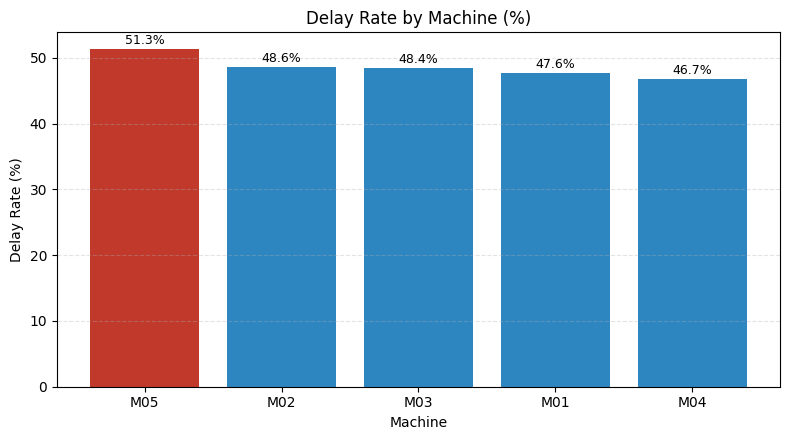

In [99]:
# Plot delay rate by machine (risk concentration)
plot_df = raw_data_df.copy()
for col in ['Scheduled_Start', 'Scheduled_End', 'Actual_Start', 'Actual_End']:
    plot_df[col] = pd.to_datetime(plot_df[col], errors='coerce')

plot_df['schedule_deviation_min'] = (plot_df['Actual_End'] - plot_df['Scheduled_End']).dt.total_seconds() / 60
plot_df['start_delay_min'] = (plot_df['Actual_Start'] - plot_df['Scheduled_Start']).dt.total_seconds() / 60
plot_df['delayed_flag'] = (
    plot_df['Job_Status'].eq('Delayed')
    | (plot_df['schedule_deviation_min'] > 0)
    | (plot_df['start_delay_min'] > 0)
)

delay_rate_by_machine = (plot_df.groupby('Machine_ID')['delayed_flag'].mean() * 100).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 4.5))
colors = ['#C0392B' if m == delay_rate_by_machine.index[0] else '#2E86C1' for m in delay_rate_by_machine.index]
ax.bar(delay_rate_by_machine.index, delay_rate_by_machine.values, color=colors)
ax.set_title('Delay Rate by Machine (%)')
ax.set_xlabel('Machine')
ax.set_ylabel('Delay Rate (%)')
ax.grid(axis='y', linestyle='--', alpha=0.35)

for i, v in enumerate(delay_rate_by_machine.values):
    ax.text(i, v + 0.3, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

highest_machine = delay_rate_by_machine.index[0]
highest_value = delay_rate_by_machine.iloc[0]
print(f'Highest-risk machine confirmed: {highest_machine} ({highest_value:.2f}% delay rate)')

plt.tight_layout()
plt.show()
